In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [2]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
!wget https://s3.amazonaws.com/kf7032-20.northumbria.ac.uk/crimes.gz

--2021-01-21 05:56:24--  https://s3.amazonaws.com/kf7032-20.northumbria.ac.uk/crimes.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.106.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.106.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487342828 (465M) [binary/octet-stream]
Saving to: ‘crimes.gz’

crimes.gz           100%[===================>] 464.77M  41.8MB/s    in 11s     

2021-01-21 05:56:35 (42.2 MB/s) - ‘crimes.gz’ saved [487342828/487342828]



In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
dataset = spark.read.csv('crimes.gz',inferSchema=True, header =False)

In [7]:
dataset.show()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+--------------------+----+
|                 _c0|    _c1|                 _c2|                 _c3|      _c4|      _c5|                 _c6|      _c7|                 _c8|                 _c9|                _c10|_c11|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+--------------------+----+
|40fc4a22e7380425d...|2014-06|Avon and Somerset...|Avon and Somerset...|-2.511761|51.409966|On or near Caerna...|E01014399|Bath and North Ea...|Criminal damage a...|Investigation com...|null|
|c70c58a712c27d96f...|2014-06|Avon and Somerset...|Avon and Somerset...|-2.515816|51.408717|On or near Caroli...|E01014399|Bath and North Ea...|       Vehicle crime|Investigation com...|null|
|042553d9545f4f15c...|2014-06|Avon and S

In [8]:
#count of nulls in data
dataset.na.df.count()

12044588

There are more firearms incidents per head in Birmingham than anywhere else in the UK

In [9]:
#filtering of the data by considering crime type as only weapon possesion
list_pw=dataset.filter(dataset._c9=='Possession of weapons').collect()

In [10]:
#using spark's topandas function to convert the sparkdf into pandasdf
df=dataset.filter(dataset._c9=='Possession of weapons').toPandas()

In [11]:
#As mentioned gun possesion crime is only considered is the offender has been sent to prison as the possesion is considered illegal
df_gun=df[df['_c10']=='Offender sent to prison']

In [14]:
#location dataframe
df_pop = spark.read.csv('/content/LSOA_pop_v2.csv',inferSchema=True, header =True)

In [15]:
#using spark's topandas function to convert the sparkdf into pandasdf
df_pop=df_pop.toPandas()

In [16]:
df_pop

,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington 001F,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...
34748,2011,Newport 020A,W01001636,Total,1897,944,953,1897,0,25,1151.60,1.6
34749,2011,Newport 020C,W01001657,Total,1465,721,744,1463,2,38,881.84,1.7
34750,2011,Newport 020D,W01001658,Total,1885,891,994,1848,37,23,365.14,5.2
34751,2011,Newport 020E,W01001912,Total,1480,739,741,1476,4,22,1607.09,0.9


In [17]:
#merging the the loaction df with gun possesion filtered df to associate the location with the crime
df_mer = df_gun.merge(df_pop,how='inner',left_on='_c7',right_on='geography code')
df_mer

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,7f0e77c4fd58992c53fc335aff1725c421aaa9e898b5ff...,2014-06,Bedfordshire Police,Bedfordshire Police,-0.454711,52.144882,On or near Amberley Gardens,E01017482,Bedford 009A,Possession of weapons,Offender sent to prison,None,2011,Bedford 009A,E01017482,Total,1344,682,662,1245,99,25,73.44,18.3
1,56c719fdbd4a5071e6f5646bc52b739d5b9b0cad387797...,2015-07,Bedfordshire Police,Bedfordshire Police,-0.457335,52.146742,On or near St Alban Road,E01017482,Bedford 009A,Possession of weapons,Offender sent to prison,None,2011,Bedford 009A,E01017482,Total,1344,682,662,1245,99,25,73.44,18.3
2,95e36cb48e7ab379257dcce4be68a5a262a78502656bf5...,2014-06,Bedfordshire Police,Bedfordshire Police,-0.453259,51.902931,On or near Sarum Road,E01015785,Luton 006G,Possession of weapons,Offender sent to prison,None,2011,Luton 006G,E01015785,Total,2134,1061,1073,2041,93,27,31.03,68.8
3,6877bc0fce36b40bdda3e86aaf424df2a88981a514e833...,2014-06,Bedfordshire Police,Bedfordshire Police,-0.419390,51.880559,On or near Alma Street,E01015794,Luton 018F,Possession of weapons,Offender sent to prison,None,2011,Luton 018F,E01015794,Total,2505,1366,1139,2060,445,48,50.51,49.6
4,9d3938e6d2b1ca53eaf023f9c6d1dc692ebd734791a05e...,2014-07,Bedfordshire Police,Bedfordshire Police,-0.418426,51.879044,On or near Peel Street,E01015794,Luton 018F,Possession of weapons,Offender sent to prison,None,2011,Luton 018F,E01015794,Total,2505,1366,1139,2060,445,48,50.51,49.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,dcda6a0d8c1f19dea3a86c39fb8d2df7298e95bc33c023...,2016-06,Metropolitan Police Service,Metropolitan Police Service,0.118440,51.610574,On or near Branch Road,E01003726,Redbridge 002D,Possession of weapons,Offender sent to prison,None,2011,Redbridge 002D,E01003726,Total,1524,722,802,1524,0,11,378.98,4.0
2999,19729bafa29ba938d0f275756eb77bb1fb6a4a6d6bbea6...,2016-06,North Wales Police,North Wales Police,-3.481766,53.324122,On or near Queen'S Walk,W01000228,Denbighshire 004C,Possession of weapons,Offender sent to prison,None,2011,Denbighshire 004C,W01000228,Total,1146,576,570,1116,30,14,50.92,22.5
3000,72d04cb4881510ff55d8d29553fb225e798f9961bfe80a...,2016-06,South Wales Police,South Wales Police,-3.966052,51.618864,On or near Uplands Terrace,W01000869,Swansea 024C,Possession of weapons,Offender sent to prison,None,2011,Swansea 024C,W01000869,Total,1590,840,750,1543,47,22,38.12,41.7
3001,2a6c9ef479f29afd923e7e30496a03287ac92e8cac4d7b...,2016-06,Thames Valley Police,Thames Valley Police,-0.747321,51.630486,On or near Priory Avenue,E01017923,Wycombe 008D,Possession of weapons,Offender sent to prison,None,2011,Wycombe 008D,E01017923,Total,1498,800,698,1475,23,17,24.52,61.1


In [18]:
#since we only need the name of city , we are removing the code attached with the city
df_mer['geography_name']=(df_mer['geography']).map(lambda x:x.split()[0])

In [19]:
#count of residents according to the city
df_mer.groupby('geography_name')['Variable: All usual residents; measures: Value'].sum()

geography_name
Adur          1395
Allerdale    12950
Amber        17940
Arun          8507
Ashfield     19114
             ...  
Wrexham      16584
Wychavon      6390
Wycombe      12814
Wyre          9064
York         25930
Name: Variable: All usual residents; measures: Value, Length: 267, dtype: int32

In [20]:
#count of firearm incidents according to city
(df_mer.groupby('geography_name')['_c9'].count())

geography_name
Adur          1
Allerdale     8
Amber        12
Arun          5
Ashfield     11
             ..
Wrexham      10
Wychavon      3
Wycombe       7
Wyre          5
York         15
Name: _c9, Length: 267, dtype: int64

Firearm incident count

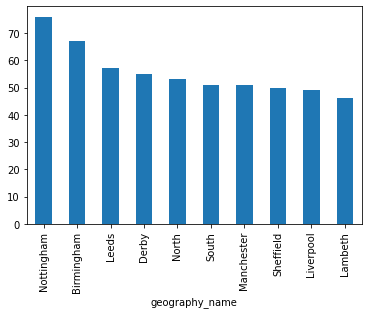

In [21]:
#plot of top 10 firearm incidents w.r.t cities 
import matplotlib.pyplot as plt

(df_mer.groupby('geography_name')['_c9'].count()).sort_values(ascending=False)[:10].plot.bar()

Firearm incident per head percentage

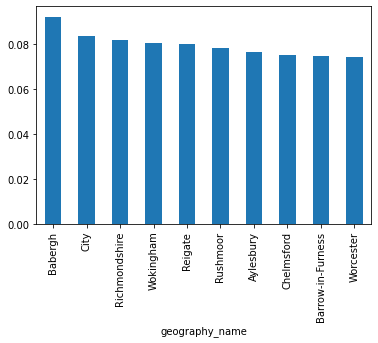

In [22]:
#plot of top 10 firearm incidents per head percent w.r.t cities
(((df_mer.groupby('geography_name')['_c9'].count())/df_mer.groupby('geography_name')['Variable: All usual residents; measures: Value'].sum())*100).sort_values(ascending=False)[:10].plot.bar()

In [23]:
#list of distinct crime type 
list_crime_type=dataset.select('_c9').distinct().collect()

In [24]:
#list of outcome category
dataset.select('_c10').distinct().show()

+--------------------+
|                _c10|
+--------------------+
|Offender ordered ...|
|Offender given su...|
|Court result unav...|
|Defendant sent to...|
|Offender given pe...|
|Suspect charged a...|
|                null|
|    Local resolution|
|Offender given a ...|
|Offender given co...|
|Investigation com...|
|Offender given ab...|
| Under investigation|
|Awaiting court ou...|
|Defendant found n...|
|Offender sent to ...|
|Further investiga...|
|Action to be take...|
|Offender given co...|
|Offender given a ...|
+--------------------+
only showing top 20 rows



Crimes involving firearms are closely associated with drugs offences

In [25]:
#fitering out the data with drug cases
df_drugs = dataset.filter(dataset._c9=='Drugs').toPandas()

No cases of sent to prison under drugs

In [26]:
df_drugs[df_drugs['_c9']=='Offender sent to prison']

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11


Firearm incident is considered only when the offender is sent to jail , since there are no cases of drugs and been sent to jail, it can be concluded that there is no such association

Violent Crime is increasing

In [27]:
#list of crime types
list_crime_type

[Row(_c9='Bicycle theft'),
 Row(_c9='Public order'),
 Row(_c9='Drugs'),
 Row(_c9='Other crime'),
 Row(_c9='Robbery'),
 Row(_c9='Criminal damage and arson'),
 Row(_c9='Theft from the person'),
 Row(_c9='Shoplifting'),
 Row(_c9='Burglary'),
 Row(_c9='Other theft'),
 Row(_c9='Possession of weapons'),
 Row(_c9='Violence and sexual offences'),
 Row(_c9='Vehicle crime'),
 Row(_c9='Anti-social behaviour')]

Violent crimes considered according to national insitiute of justice are Robbery, Violence and sexual assault,murder

Hence filtering the data with only cases involving Robbery,crimanl damage and violence and assualt

In [28]:
df_rob = dataset.filter(dataset._c9==('Robbery')).toPandas()

In [29]:
df_cd = dataset.filter(dataset._c9==('Criminal damage and arson')).toPandas()

In [ ]:
df_vs = dataset.filter(dataset._c9==('Violence and sexual offences')).toPandas()

In [30]:
df_vs = dataset.filter(dataset._c9==('Violence and sexual offences'))

In [35]:
df_vs.show()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+--------------------+----+
|                 _c0|    _c1|                 _c2|                 _c3|      _c4|      _c5|                 _c6|      _c7|                 _c8|                 _c9|                _c10|_c11|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+--------------------+----+
|751b8fb098629781a...|2014-06|Avon and Somerset...|Avon and Somerset...|-2.512773|51.411751|On or near Westfi...|E01014399|Bath and North Ea...|Violence and sexu...|Unable to prosecu...|null|
|81e1cf35259deb6cb...|2014-06|Avon and Somerset...|Avon and Somerset...|-2.515816|51.408717|On or near Caroli...|E01014399|Bath and North Ea...|Violence and sexu...|Unable to prosecu...|null|
|d2120efc607527883...|2014-06|Avon and S

In [41]:
from pyspark.sql import functions as F
df2_vs = df_vs.select('_c9', F.split('_c1', '-')[0].alias('year'))
df2_vs.show()

+--------------------+----+
|                 _c9|year|
+--------------------+----+
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
|Violence and sexu...|2014|
+--------------------+----+
only showing top 20 rows



In [46]:
df_vsp=df2_vs.groupby('year').count().toPandas()

Creating new column of year to get the total count of respective crime in the respective year

In [50]:
df_rob['year']=df_rob['_c1'].map(lambda x:x.split('-')[0])

In [51]:
#count of robbery wrt year
s1=df_rob.groupby('year')['_c9'].count()

In [52]:
df_cd['year']=df_cd['_c1'].map(lambda x:x.split('-')[0])

In [53]:
#count of criminal damage year wise
s2=df_cd.groupby('year')['_c9'].count()

In [61]:
#count of violence and assualt year wise
s3=df_vsp.groupby('year')['count'].sum()

From following result it can be seen that there was increase in violent crime in 2015 but showed a massive decrease in 2016 

In [62]:
#addition of these crime year wise will give us the total cases of considered violent crime year wise. 
s1+s2+s3

year
2014     861605
2015    1649934
2016     894547
dtype: int64